# imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
import matplotlib.pyplot as plt
import time
import torch

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## function & derivatives

In [3]:
def sphere(x, grads=False):
    if grads == False:
        return torch.sum(x**2, dim=0)
    else:
        values = torch.sum(x**2, dim=0)
        values.backward(torch.ones_like(values))
        return values, x.grad

In [4]:
def ackley(x, grads=False):
    a = 20
    b = 0.2
    c = 2 * torch.pi
    d = x.shape[0]
    if grads == False:
        sum1 = torch.sum(x**2, dim=0)
        sum2 = torch.sum(torch.cos(c * x), dim=0)
        return -a * torch.exp(-b * torch.sqrt(sum1 / d)) - torch.exp(sum2 / d) + a + math.exp(1)
    else:
        values = -a * torch.exp(-b * torch.sqrt(torch.sum(x**2, dim=0) / d)) - torch.exp(torch.sum(torch.cos(c * x), dim=0) / d) + a + math.exp(1)
        values.backward(torch.ones_like(values))
        return values, x.grad

In [5]:
def rastrigin(x, grads=False):
    A = 10
    if grads == False:
        return A * x.shape[0] + torch.sum(x**2 - A * torch.cos(2 * torch.pi * x), dim=0)
    else:
        values = A * x.shape[0] + torch.sum(x**2 - A * torch.cos(2 * torch.pi * x), dim=0)
        values.backward(torch.ones_like(values))
        return values, x.grad

In [6]:
def rosenbrock(x, grads = False):
    if grads == False:
        return torch.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2, dim = 0)
    else:
        values = torch.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2, dim = 0)
        values.backward(torch.ones_like(values))
        return values, x.grad

In [7]:
def SODP(x, grads=False):
    device = x.device
    if grads == False:
        return torch.sum(torch.abs(x)**(torch.arange(2, x.shape[0]+2, device=device)[:, None]), dim=0)
    else:
        values = torch.sum(torch.abs(x)**(torch.arange(2, x.shape[0]+2, device=device)[:, None]), dim=0)
        values.backward(torch.ones_like(values))
        return values, x.grad

In [8]:
def elliptic(x, grads=False):
    device = x.device
    if grads == False:
        return torch.sum((torch.arange(1, x.shape[0]+1, device=device)[:, None])*torch.pow(1e6, -torch.arange(x.shape[0]-1, -1, -1, device=device)[:, None])*torch.pow(x, 2), dim=0)
    else:
        values = torch.sum((torch.arange(1, x.shape[0]+1, device=device)[:, None])*torch.pow(1e6, -torch.arange(x.shape[0]-1, -1, -1, device=device)[:, None])*torch.pow(x, 2), dim=0)
        values.backward(torch.ones_like(values))
        return values, x.grad

In [9]:
def griewank(x, grads=False):
    device = x.device
    n = x.shape[0]
    term1 = torch.sum(torch.pow(x, 2), dim=0) / 4000
    term2 = torch.prod(torch.cos(x / torch.sqrt(torch.arange(1, n+1, device=device)[:,None])), dim=0)
    if grads == False:
        return 1 + term1 - term2
    else:
        values = 1 + term1 - term2
        values.backward(torch.ones_like(values))
        return values, x.grad

# GRIEWANK

## func, xmean, dim

In [10]:
N = 5000
strfitnessfct = griewank
stopfitness = 1e-3
xmean = 0.1*torch.ones((N,1), dtype=torch.float64).to(device) + 0.01 * torch.randn(N,1, dtype = torch.float64).to(device)
xmin = xmean

## FINDER

### initialisations

In [11]:
R = 0.1 * torch.ones((1,N), dtype = torch.float64).to(device)
Γ = torch.zeros((N,1), dtype=torch.float64).to(device)
rand = torch.empty(4,N, dtype=torch.float64).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [12]:
def generate_arx(x, r, num = 5):
    arx_ = torch.from_numpy(np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1))
    return arx_.detach().requires_grad_(True)

In [13]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [14]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [15]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [16]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [17]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [18]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [19]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    # arx = generate_arx(xmin, R)
    
    arx_ = xmin + torch.cat([(R * rand.uniform_(-1,1)).T, torch.zeros_like(xmin)], dim = 1)
    arx = torch.tensor(arx_, requires_grad=True)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(f"Epoch {it} loss {fx[it]:.4f}")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >3000:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

/tmp/ipykernel_1114732/2745831488.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arx = torch.tensor(arx_, requires_grad=True)


Epoch 0 loss 0.0578
Epoch 1 loss 0.0000
reached tolerance for griewank function in 0.3211 seconds


In [20]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [21]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [22]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.0578
epoch: 2 loss: 0.0567
epoch: 3 loss: 0.0556
epoch: 4 loss: 0.0545
epoch: 5 loss: 0.0534
epoch: 6 loss: 0.0523
epoch: 7 loss: 0.0513
epoch: 8 loss: 0.0502
epoch: 9 loss: 0.0492
epoch: 10 loss: 0.0482
epoch: 11 loss: 0.0471
epoch: 12 loss: 0.0461
epoch: 13 loss: 0.0452
epoch: 14 loss: 0.0442
epoch: 15 loss: 0.0432
epoch: 16 loss: 0.0423
epoch: 17 loss: 0.0413
epoch: 18 loss: 0.0404
epoch: 19 loss: 0.0395
epoch: 20 loss: 0.0386
epoch: 21 loss: 0.0377
epoch: 22 loss: 0.0368
epoch: 23 loss: 0.0360
epoch: 24 loss: 0.0351
epoch: 25 loss: 0.0343
epoch: 26 loss: 0.0335
epoch: 27 loss: 0.0327
epoch: 28 loss: 0.0319
epoch: 29 loss: 0.0311
epoch: 30 loss: 0.0303
epoch: 31 loss: 0.0296
epoch: 32 loss: 0.0288
epoch: 33 loss: 0.0281
epoch: 34 loss: 0.0274
epoch: 35 loss: 0.0267
epoch: 36 loss: 0.0260
epoch: 37 loss: 0.0253
epoch: 38 loss: 0.0247
epoch: 39 loss: 0.0240
epoch: 40 loss: 0.0234
epoch: 41 loss: 0.0228
epoch: 42 loss: 0.0222
epoch: 43 loss: 0.0216
epoch: 44 loss: 0.02

## LBFGS

In [23]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [24]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.0578
epoch: 2 loss: 0.0041
epoch: 3 loss: 0.0000
finished in  0.22010040283203125  seconds


## plotting

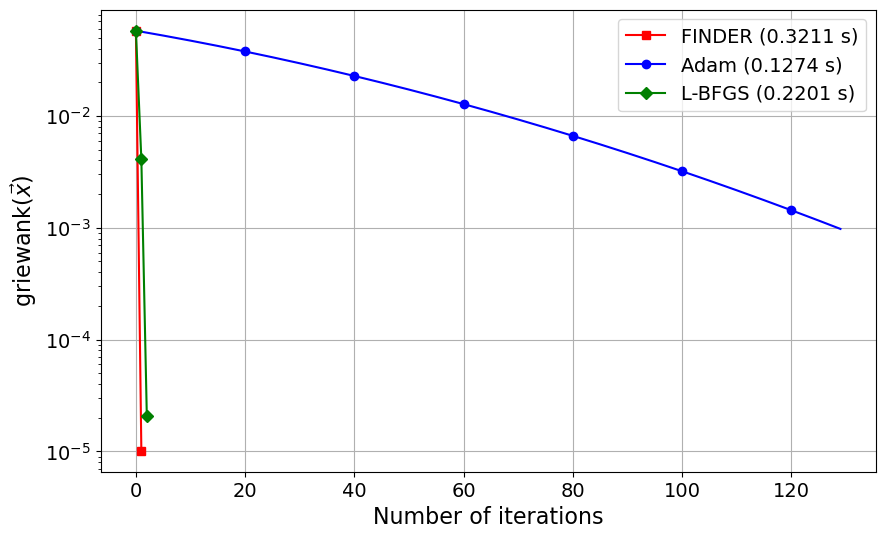

In [25]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 1, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 20, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [26]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')

# ROSENBROCK

## func, xmean, dim

In [27]:
N = 5000
strfitnessfct = rosenbrock
stopfitness = 1e-3
xmean = 1.1*torch.ones((N,1), dtype=torch.float64).to(device) + 0.01 * torch.randn(N,1, dtype = torch.float64).to(device)
xmin = xmean

## FINDER

### initialisations

In [28]:
R = 0.1 * torch.ones((1,N), dtype = torch.float64).to(device)
Γ = torch.zeros((N,1), dtype=torch.float64).to(device)
rand = torch.empty(4,N, dtype=torch.float64).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [29]:
def generate_arx(x, r, num = 5):
    arx_ = torch.from_numpy(np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1))
    return arx_.detach().requires_grad_(True)

In [30]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [31]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [32]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [33]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [34]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [35]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [36]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    # arx = generate_arx(xmin, R)
    
    arx_ = xmin + torch.cat([(R * rand.uniform_(-1,1)).T, torch.zeros_like(xmin)], dim = 1)
    arx = torch.tensor(arx_, requires_grad=True)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(f"Epoch {it} loss {fx[it]:.4f}")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >3000:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

/tmp/ipykernel_1114732/2745831488.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arx = torch.tensor(arx_, requires_grad=True)


Epoch 0 loss 6382.4033
Epoch 1 loss 4121.3638
Epoch 2 loss 1899.8426
Epoch 3 loss 426.0653
Epoch 4 loss 232.0537
Epoch 5 loss 219.1602
Epoch 6 loss 212.0688
Epoch 7 loss 212.0671
Epoch 8 loss 204.3359
Epoch 9 loss 202.6767
Epoch 10 loss 200.2917
Epoch 11 loss 197.3467
Epoch 12 loss 195.1696
Epoch 13 loss 194.2498
Epoch 14 loss 188.1715
Epoch 15 loss 176.3937
Epoch 16 loss 163.1317
Epoch 17 loss 145.1775
Epoch 18 loss 138.4119
Epoch 19 loss 125.4148
Epoch 20 loss 122.5516
Epoch 21 loss 119.3716
Epoch 22 loss 117.4709
Epoch 23 loss 117.1080
Epoch 24 loss 110.2771
Epoch 25 loss 104.3967
Epoch 26 loss 88.7351
Epoch 27 loss 83.5725
Epoch 28 loss 72.7013
Epoch 29 loss 59.0713
Epoch 30 loss 53.3037
Epoch 31 loss 51.7811
Epoch 32 loss 48.4922
Epoch 33 loss 45.3990
Epoch 34 loss 42.1503
Epoch 35 loss 38.2370
Epoch 36 loss 37.0344
Epoch 37 loss 33.1322
Epoch 38 loss 32.2982
Epoch 39 loss 29.7183
Epoch 40 loss 25.0695
Epoch 41 loss 22.6742
Epoch 42 loss 21.7290
Epoch 43 loss 20.4028
Epoch 44 loss

In [37]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [38]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [39]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 6382.4033
epoch: 2 loss: 6248.8503
epoch: 3 loss: 6117.3845
epoch: 4 loss: 5987.9318
epoch: 5 loss: 5860.4183
epoch: 6 loss: 5734.7874
epoch: 7 loss: 5610.9999
epoch: 8 loss: 5489.0307
epoch: 9 loss: 5368.8656
epoch: 10 loss: 5250.4984
epoch: 11 loss: 5133.9280
epoch: 12 loss: 5019.1563
epoch: 13 loss: 4906.1866
epoch: 14 loss: 4795.0225
epoch: 15 loss: 4685.6671
epoch: 16 loss: 4578.1228
epoch: 17 loss: 4472.3906
epoch: 18 loss: 4368.4704
epoch: 19 loss: 4266.3603
epoch: 20 loss: 4166.0567
epoch: 21 loss: 4067.5547
epoch: 22 loss: 3970.8476
epoch: 23 loss: 3875.9272
epoch: 24 loss: 3782.7839
epoch: 25 loss: 3691.4069
epoch: 26 loss: 3601.7839
epoch: 27 loss: 3513.9018
epoch: 28 loss: 3427.7462
epoch: 29 loss: 3343.3015
epoch: 30 loss: 3260.5514
epoch: 31 loss: 3179.4787
epoch: 32 loss: 3100.0652
epoch: 33 loss: 3022.2924
epoch: 34 loss: 2946.1407
epoch: 35 loss: 2871.5902
epoch: 36 loss: 2798.6206
epoch: 37 loss: 2727.2108
epoch: 38 loss: 2657.3395
epoch: 39 loss: 2588.

## LBFGS

In [40]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [41]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 6382.4033
epoch: 2 loss: 0.0054
epoch: 3 loss: 0.0000
finished in  0.11818671226501465  seconds


## plotting

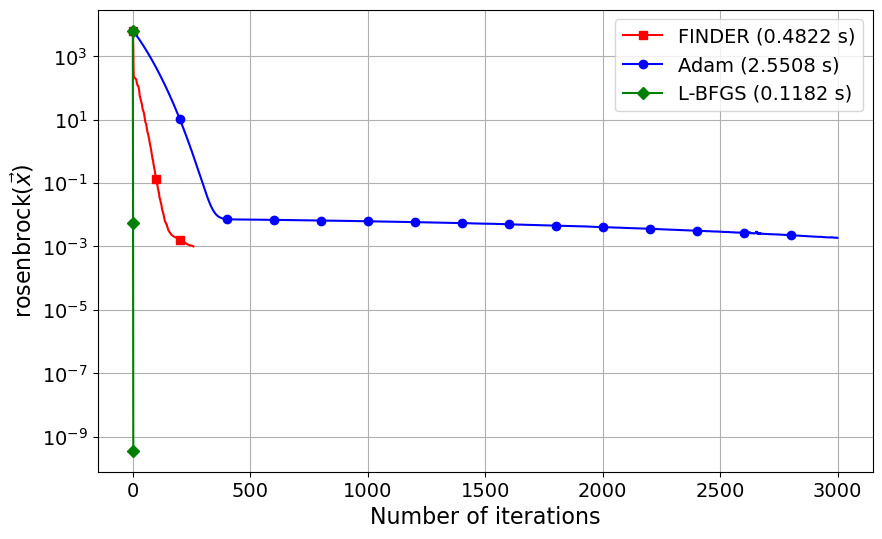

In [42]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 100, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 200, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [43]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')

# SODP

## func, xmean, dim

In [44]:
N = 5000
strfitnessfct = SODP
stopfitness = 1e-3
xmean = 0.1*torch.ones((N,1), dtype=torch.float64).to(device) + 0.01 * torch.randn(N,1, dtype = torch.float64).to(device)
xmin = xmean

## FINDER

### initialisations

In [45]:
R = 0.1 * torch.ones((1,N), dtype = torch.float64).to(device)
Γ = torch.zeros((N,1), dtype=torch.float64).to(device)
rand = torch.empty(4,N, dtype=torch.float64).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [46]:
def generate_arx(x, r, num = 5):
    return torch.cat([x,x + (r * (2*torch.rand(num-1, x.shape[0]).to(device)-1)).T], dim = 1).detach().requires_grad_(True)

In [47]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [48]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [49]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [50]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [51]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [52]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [53]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    # arx = generate_arx(xmin, R)
    arx_ = xmin + torch.cat([(R * rand.uniform_(-1,1)).T, torch.zeros_like(xmin)], dim = 1)
    arx = torch.tensor(arx_, requires_grad=True)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fx[it],"\n")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >999:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

/tmp/ipykernel_1114732/2769289989.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arx = torch.tensor(arx_, requires_grad=True)


0 	 0.013836797699148558 

Epoch 1 loss 0.0040
Epoch 2 loss 0.0040
Epoch 3 loss 0.0040
Epoch 4 loss 0.0040
Epoch 5 loss 0.0040
Epoch 6 loss 0.0040
Epoch 7 loss 0.0040
Epoch 8 loss 0.0040
Epoch 9 loss 0.0040
Epoch 10 loss 0.0039
Epoch 11 loss 0.0039
Epoch 12 loss 0.0039
Epoch 13 loss 0.0039
Epoch 14 loss 0.0039
Epoch 15 loss 0.0039
Epoch 16 loss 0.0039
Epoch 17 loss 0.0039
Epoch 18 loss 0.0039
Epoch 19 loss 0.0039
Epoch 20 loss 0.0039
Epoch 21 loss 0.0039
Epoch 22 loss 0.0038
Epoch 23 loss 0.0038
Epoch 24 loss 0.0038
Epoch 25 loss 0.0038
Epoch 26 loss 0.0038
Epoch 27 loss 0.0038
Epoch 28 loss 0.0038
Epoch 29 loss 0.0038
Epoch 30 loss 0.0038
Epoch 31 loss 0.0038
Epoch 32 loss 0.0038
Epoch 33 loss 0.0038
Epoch 34 loss 0.0038
Epoch 35 loss 0.0038
Epoch 36 loss 0.0037
Epoch 37 loss 0.0037
Epoch 38 loss 0.0037
Epoch 39 loss 0.0037
Epoch 40 loss 0.0037
Epoch 41 loss 0.0037
Epoch 42 loss 0.0037
Epoch 43 loss 0.0037
Epoch 44 loss 0.0037
Epoch 45 loss 0.0037
Epoch 46 loss 0.0037
Epoch 47 loss 0.

In [54]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [55]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [56]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.0138
epoch: 2 loss: 0.0136
epoch: 3 loss: 0.0133
epoch: 4 loss: 0.0131
epoch: 5 loss: 0.0128
epoch: 6 loss: 0.0126
epoch: 7 loss: 0.0123
epoch: 8 loss: 0.0121
epoch: 9 loss: 0.0118
epoch: 10 loss: 0.0116
epoch: 11 loss: 0.0114
epoch: 12 loss: 0.0111
epoch: 13 loss: 0.0109
epoch: 14 loss: 0.0107
epoch: 15 loss: 0.0104
epoch: 16 loss: 0.0102
epoch: 17 loss: 0.0100
epoch: 18 loss: 0.0098
epoch: 19 loss: 0.0096
epoch: 20 loss: 0.0094
epoch: 21 loss: 0.0092
epoch: 22 loss: 0.0090
epoch: 23 loss: 0.0088
epoch: 24 loss: 0.0086
epoch: 25 loss: 0.0084
epoch: 26 loss: 0.0082
epoch: 27 loss: 0.0080
epoch: 28 loss: 0.0079
epoch: 29 loss: 0.0077
epoch: 30 loss: 0.0075
epoch: 31 loss: 0.0073
epoch: 32 loss: 0.0072
epoch: 33 loss: 0.0070
epoch: 34 loss: 0.0068
epoch: 35 loss: 0.0067
epoch: 36 loss: 0.0065
epoch: 37 loss: 0.0064
epoch: 38 loss: 0.0062
epoch: 39 loss: 0.0061
epoch: 40 loss: 0.0059
epoch: 41 loss: 0.0058
epoch: 42 loss: 0.0056
epoch: 43 loss: 0.0055
epoch: 44 loss: 0.00

## LBFGS

In [57]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [58]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.0138
epoch: 2 loss: 0.0000
finished in  0.04476332664489746  seconds


## plotting

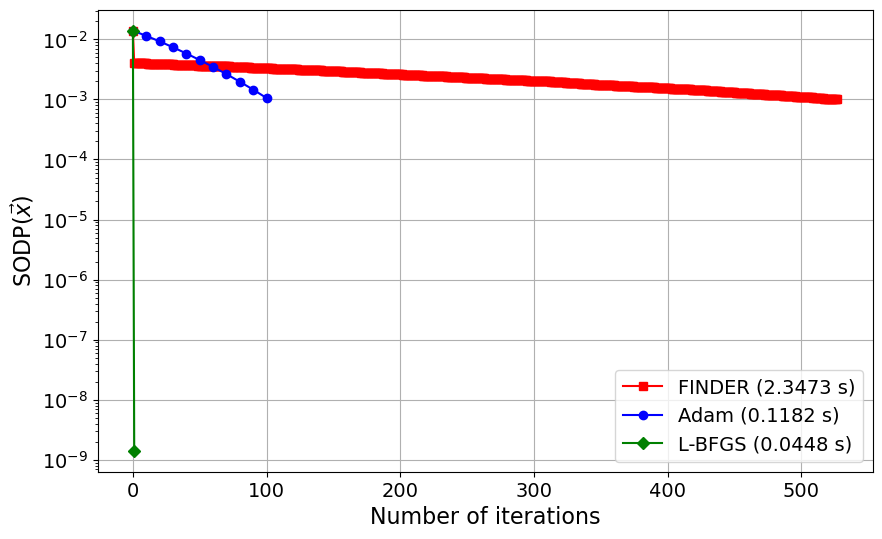

In [59]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 1, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 10, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [60]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')

# SPHERE

## func, xmean, dim

In [61]:
N = 5000
strfitnessfct = sphere
stopfitness = 1e-3
xmean = 0.1*torch.ones((N,1)).to(device) + 0.01 * torch.randn(N,1).to(device)
xmin = xmean

## FINDER

### initialisations

In [62]:
R = 0.1 * torch.ones((1,N)).to(device)
Γ = torch.zeros((N,1)).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [63]:
def generate_arx(x, r, num = 5):
    return torch.cat([x,x + (r * (2*torch.rand(num-1, x.shape[0]).to(device)-1)).T], dim = 1).detach().requires_grad_(True)

In [64]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [65]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [66]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [67]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [68]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [69]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [70]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fx[it],"\n")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >999:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

0 	 50.68508529663086 

Epoch 1 loss 0.0000
reached tolerance for sphere function in 0.0111 seconds


In [71]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [72]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [73]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 50.6851
epoch: 2 loss: 49.6883
epoch: 3 loss: 48.7017
epoch: 4 loss: 47.7256
epoch: 5 loss: 46.7601
epoch: 6 loss: 45.8054
epoch: 7 loss: 44.8616
epoch: 8 loss: 43.9289
epoch: 9 loss: 43.0073
epoch: 10 loss: 42.0971
epoch: 11 loss: 41.1984
epoch: 12 loss: 40.3112
epoch: 13 loss: 39.4358
epoch: 14 loss: 38.5721
epoch: 15 loss: 37.7203
epoch: 16 loss: 36.8804
epoch: 17 loss: 36.0525
epoch: 18 loss: 35.2367
epoch: 19 loss: 34.4330
epoch: 20 loss: 33.6415
epoch: 21 loss: 32.8622
epoch: 22 loss: 32.0951
epoch: 23 loss: 31.3402
epoch: 24 loss: 30.5976
epoch: 25 loss: 29.8672
epoch: 26 loss: 29.1490
epoch: 27 loss: 28.4431
epoch: 28 loss: 27.7493
epoch: 29 loss: 27.0676
epoch: 30 loss: 26.3980
epoch: 31 loss: 25.7405
epoch: 32 loss: 25.0950
epoch: 33 loss: 24.4613
epoch: 34 loss: 23.8396
epoch: 35 loss: 23.2295
epoch: 36 loss: 22.6312
epoch: 37 loss: 22.0445
epoch: 38 loss: 21.4693
epoch: 39 loss: 20.9056
epoch: 40 loss: 20.3531
epoch: 41 loss: 19.8118
epoch: 42 loss: 19.2817
e

## LBFGS

In [74]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [75]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 50.6851
epoch: 2 loss: 0.0000
finished in  0.009331941604614258  seconds


## plotting

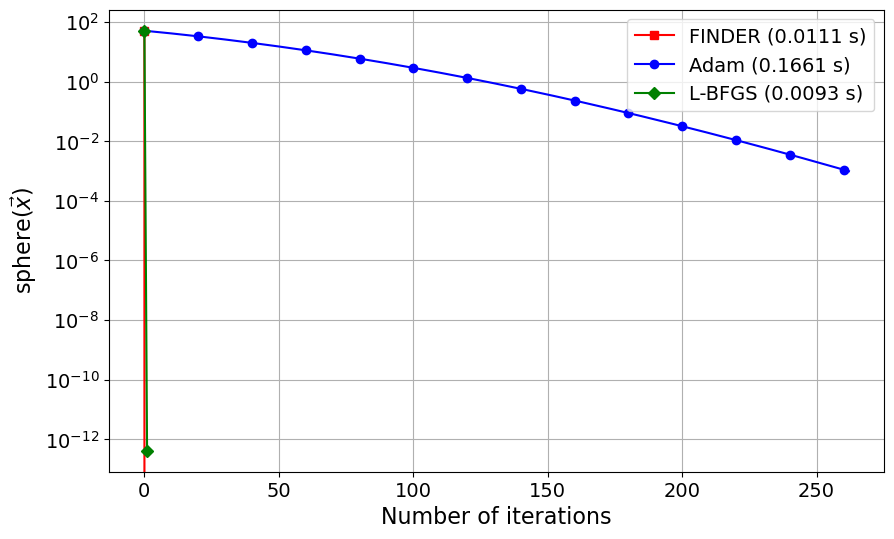

In [76]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 1, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 20, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [77]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')

# ACKLEY

## func, xmean, dim

In [78]:
N = 5000
strfitnessfct = ackley
stopfitness = 1e-3
xmean = 0.1*torch.ones((N,1)).to(device) + 0.01 * torch.randn(N,1).to(device)
xmin = xmean

## FINDER

### initialisations

In [79]:
R = 0.1 * torch.ones((1,N)).to(device)
Γ = torch.zeros((N,1)).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [80]:
def generate_arx(x, r, num = 5):
    return torch.cat([x,x + (r * (2*torch.rand(num-1, x.shape[0]).to(device)-1)).T], dim = 1).detach().requires_grad_(True)

In [81]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [82]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [83]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [84]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [85]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [86]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [87]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fx[it],"\n")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >999:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

0 	 0.8750505447387695 

Epoch 1 loss 0.0953
Epoch 2 loss 0.0953
Epoch 3 loss 0.0953
Epoch 4 loss 0.0953
Epoch 5 loss 0.0931
Epoch 6 loss 0.0884
Epoch 7 loss 0.0843
Epoch 8 loss 0.0761
Epoch 9 loss 0.0664
Epoch 10 loss 0.0590
Epoch 11 loss 0.0554
Epoch 12 loss 0.0496
Epoch 13 loss 0.0470
Epoch 14 loss 0.0441
Epoch 15 loss 0.0430
Epoch 16 loss 0.0408
Epoch 17 loss 0.0388
Epoch 18 loss 0.0370
Epoch 19 loss 0.0351
Epoch 20 loss 0.0330
Epoch 21 loss 0.0309
Epoch 22 loss 0.0288
Epoch 23 loss 0.0271
Epoch 24 loss 0.0255
Epoch 25 loss 0.0239
Epoch 26 loss 0.0222
Epoch 27 loss 0.0207
Epoch 28 loss 0.0195
Epoch 29 loss 0.0186
Epoch 30 loss 0.0179
Epoch 31 loss 0.0172
Epoch 32 loss 0.0163
Epoch 33 loss 0.0154
Epoch 34 loss 0.0152
Epoch 35 loss 0.0151
Epoch 36 loss 0.0142
Epoch 37 loss 0.0137
Epoch 38 loss 0.0126
Epoch 39 loss 0.0121
Epoch 40 loss 0.0111
Epoch 41 loss 0.0107
Epoch 42 loss 0.0099
Epoch 43 loss 0.0096
Epoch 44 loss 0.0089
Epoch 45 loss 0.0087
Epoch 46 loss 0.0080
Epoch 47 loss 0.00

In [88]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [89]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [90]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.8751
epoch: 2 loss: 0.8629
epoch: 3 loss: 0.8508
epoch: 4 loss: 0.8387
epoch: 5 loss: 0.8267
epoch: 6 loss: 0.8148
epoch: 7 loss: 0.8028
epoch: 8 loss: 0.7910
epoch: 9 loss: 0.7792
epoch: 10 loss: 0.7674
epoch: 11 loss: 0.7557
epoch: 12 loss: 0.7441
epoch: 13 loss: 0.7325
epoch: 14 loss: 0.7210
epoch: 15 loss: 0.7095
epoch: 16 loss: 0.6981
epoch: 17 loss: 0.6868
epoch: 18 loss: 0.6756
epoch: 19 loss: 0.6644
epoch: 20 loss: 0.6533
epoch: 21 loss: 0.6422
epoch: 22 loss: 0.6313
epoch: 23 loss: 0.6204
epoch: 24 loss: 0.6096
epoch: 25 loss: 0.5989
epoch: 26 loss: 0.5883
epoch: 27 loss: 0.5777
epoch: 28 loss: 0.5672
epoch: 29 loss: 0.5569
epoch: 30 loss: 0.5466
epoch: 31 loss: 0.5364
epoch: 32 loss: 0.5263
epoch: 33 loss: 0.5162
epoch: 34 loss: 0.5063
epoch: 35 loss: 0.4965
epoch: 36 loss: 0.4867
epoch: 37 loss: 0.4771
epoch: 38 loss: 0.4675
epoch: 39 loss: 0.4581
epoch: 40 loss: 0.4488
epoch: 41 loss: 0.4395
epoch: 42 loss: 0.4304
epoch: 43 loss: 0.4213
epoch: 44 loss: 0.41

## LBFGS

In [91]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [92]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.8751
epoch: 2 loss: 0.0000
finished in  0.10139632225036621  seconds


## plotting

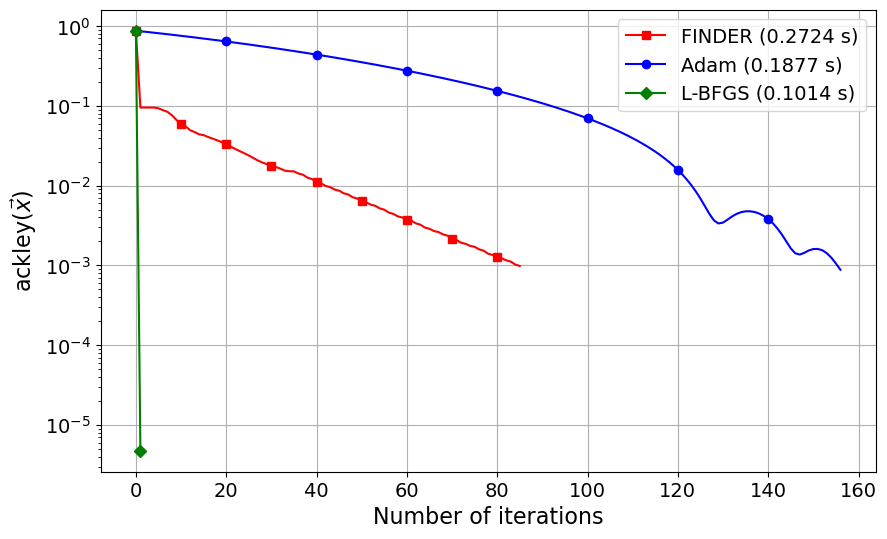

In [93]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 10, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 20, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [94]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')

# RASTRIGIN

## func, xmean, dim

In [95]:
N = 5000
strfitnessfct = rastrigin
stopfitness = 1e-3
xmean = 0.1*torch.ones((N,1)).to(device) + 0.01 * torch.randn(N,1).to(device)
xmin = xmean

## FINDER

### initialisations

In [96]:
R = 0.1 * torch.ones((1,N)).to(device)
Γ = torch.zeros((N,1)).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [97]:
def generate_arx(x, r, num = 5):
    return torch.cat([x,x + (r * (2*torch.rand(num-1, x.shape[0]).to(device)-1)).T], dim = 1).detach().requires_grad_(True)

In [98]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [99]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [100]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [101]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [102]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [103]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [104]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fx[it],"\n")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >999:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

0 	 9692.4296875 

Epoch 1 loss 517.9297
Epoch 2 loss 517.9062
Epoch 3 loss 517.9023
Epoch 4 loss 517.8750
Epoch 5 loss 491.6719
Epoch 6 loss 468.8672
Epoch 7 loss 350.7109
Epoch 8 loss 267.2852
Epoch 9 loss 242.8594
Epoch 10 loss 188.9883
Epoch 11 loss 183.1094
Epoch 12 loss 156.7344
Epoch 13 loss 151.9219
Epoch 14 loss 132.8750
Epoch 15 loss 126.3359
Epoch 16 loss 112.5898
Epoch 17 loss 105.3203
Epoch 18 loss 88.6250
Epoch 19 loss 80.6328
Epoch 20 loss 68.7773
Epoch 21 loss 63.3594
Epoch 22 loss 53.0781
Epoch 23 loss 49.3633
Epoch 24 loss 43.5156
Epoch 25 loss 40.9219
Epoch 26 loss 36.3438
Epoch 27 loss 34.0703
Epoch 28 loss 28.8750
Epoch 29 loss 26.6523
Epoch 30 loss 22.7812
Epoch 31 loss 21.2969
Epoch 32 loss 18.9375
Epoch 33 loss 17.9414
Epoch 34 loss 15.6406
Epoch 35 loss 14.5078
Epoch 36 loss 12.1836
Epoch 37 loss 11.2891
Epoch 38 loss 9.8320
Epoch 39 loss 9.3203
Epoch 40 loss 8.2969
Epoch 41 loss 7.7734
Epoch 42 loss 6.6016
Epoch 43 loss 6.0781
Epoch 44 loss 5.1641
Epoch 45 los

In [105]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [106]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [107]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 9692.4297
epoch: 2 loss: 9507.7891
epoch: 3 loss: 9324.8125
epoch: 4 loss: 9143.5156
epoch: 5 loss: 8963.9453
epoch: 6 loss: 8786.1328
epoch: 7 loss: 8610.1094
epoch: 8 loss: 8435.9062
epoch: 9 loss: 8263.5586
epoch: 10 loss: 8093.0938
epoch: 11 loss: 7924.5312
epoch: 12 loss: 7757.9141
epoch: 13 loss: 7593.2539
epoch: 14 loss: 7430.5859
epoch: 15 loss: 7269.9258
epoch: 16 loss: 7111.2969
epoch: 17 loss: 6954.7227
epoch: 18 loss: 6800.2188
epoch: 19 loss: 6647.7969
epoch: 20 loss: 6497.4844
epoch: 21 loss: 6349.2852
epoch: 22 loss: 6203.2109
epoch: 23 loss: 6059.2812
epoch: 24 loss: 5917.5000
epoch: 25 loss: 5777.8750
epoch: 26 loss: 5640.4062
epoch: 27 loss: 5505.1094
epoch: 28 loss: 5371.9766
epoch: 29 loss: 5241.0156
epoch: 30 loss: 5112.2266
epoch: 31 loss: 4985.6094
epoch: 32 loss: 4861.1523
epoch: 33 loss: 4738.8594
epoch: 34 loss: 4618.7227
epoch: 35 loss: 4500.7344
epoch: 36 loss: 4384.8906
epoch: 37 loss: 4271.1797
epoch: 38 loss: 4159.5859
epoch: 39 loss: 4050.

## LBFGS

In [108]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [109]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 9692.4297
epoch: 2 loss: 0.0000
finished in  0.05756115913391113  seconds


## plotting

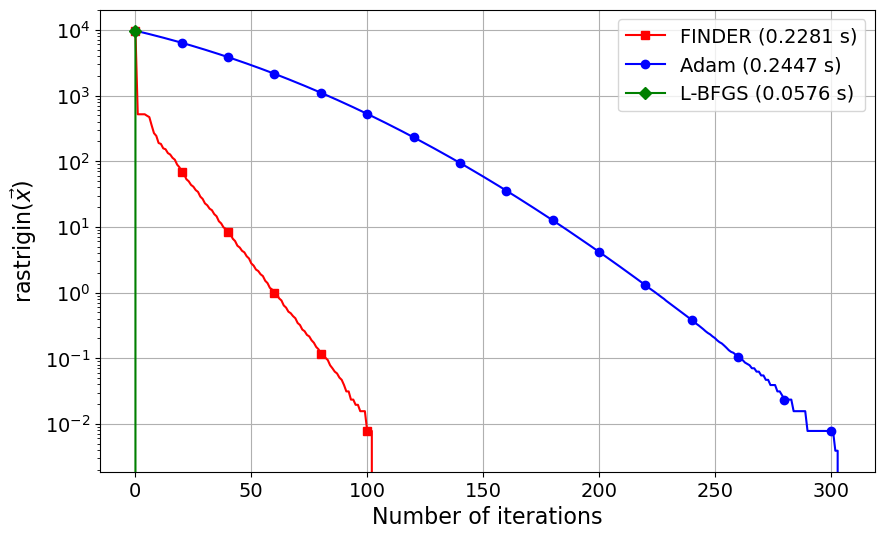

In [110]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 20, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 20, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [111]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')

# ELLIPTIC

## func, xmean, dim

In [112]:
N = 5000
strfitnessfct = elliptic
stopfitness = 1e-3
xmean = 0.1*torch.ones((N,1)).to(device) + 0.01 * torch.randn(N,1,).to(device)
xmin = xmean

## FINDER

### initialisations

In [113]:
R = 0.1 * torch.ones((1,N)).to(device)
Γ = torch.zeros((N,1)).to(device)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
clamps = [1e-4, 1e-4]

### helper functions

In [114]:
def generate_arx(x, r, num = 5):
    return torch.cat([x,x + (r * (2*torch.rand(num-1, x.shape[0]).to(device)-1)).T], dim = 1).detach().requires_grad_(True)

In [115]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y, y_grad = strfitnessfct(x, grads= True)
        
        y_sorted, sorted_indices = torch.sort(y)
        
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x, grads=False)
        y_sorted, sorted_indices = torch.sort(y)
        
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [116]:
def calc_invH(x, x_grad, γ = 1):
    with torch.no_grad():
        a = x - torch.mean(x, dim = 1).view(-1,1)
        b = x_grad - torch.mean(x_grad, dim = 1).view(-1,1)
        c = torch.sum(a*b, dim = 1)
        d = torch.sum(b*b, dim = 1)
        Hinv = (c / d).reshape(-1,1)
        Hinv = torch.nan_to_num(Hinv)
        Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [117]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    with torch.no_grad():
        ps = (1 - cs) * ps + cs * (xmax - xmin)
        sig = torch.minimum(torch.abs(ps.T), clamps[0] * torch.ones_like(ps.T))
        sig[sig == 0.0] = clamps[1]
        return sig, ps

In [118]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [119]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [120]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x, grads=False)
        # g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            # x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

### FINDER loop

In [121]:
fx = [strfitnessfct(xmean, grads=False).item()]
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = torch.cat([arx_new, xmiin], dim = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    
    fx.append(min_fitness.item())
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fx[it],"\n")
    it += 1
    print(f"Epoch {it} loss {fx[it]:.4f}")
    
    '''
    termination criteria
    '''
    if min_fitness.item() <= stopfitness or it >999:
        break

toc = time.time()
runtime_FINDER = round(toc - tic, 4)
print(f"reached tolerance for {strfitnessfct.__name__} function in {(toc - tic):.4f} seconds")

0 	 44.73224639892578 

Epoch 1 loss 0.0002
reached tolerance for elliptic function in 0.0031 seconds


In [122]:
runtime_FINDER = round(toc-tic, 4)

## Adam

In [123]:
x_adam = xmean.clone().detach().requires_grad_(True).to(device)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [124]:
fx_adam = []
tic = time.time()
for i in range(3000):
    adam.zero_grad()
    loss, _ = strfitnessfct(x_adam, grads = True)
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 44.7322
epoch: 2 loss: 43.7914
epoch: 3 loss: 42.8608
epoch: 4 loss: 41.9406
epoch: 5 loss: 41.0311
epoch: 6 loss: 40.1323
epoch: 7 loss: 39.2445
epoch: 8 loss: 38.3677
epoch: 9 loss: 37.5021
epoch: 10 loss: 36.6479
epoch: 11 loss: 35.8051
epoch: 12 loss: 34.9739
epoch: 13 loss: 34.1543
epoch: 14 loss: 33.3465
epoch: 15 loss: 32.5506
epoch: 16 loss: 31.7665
epoch: 17 loss: 30.9945
epoch: 18 loss: 30.2345
epoch: 19 loss: 29.4866
epoch: 20 loss: 28.7508
epoch: 21 loss: 28.0272
epoch: 22 loss: 27.3158
epoch: 23 loss: 26.6165
epoch: 24 loss: 25.9294
epoch: 25 loss: 25.2545
epoch: 26 loss: 24.5917
epoch: 27 loss: 23.9411
epoch: 28 loss: 23.3025
epoch: 29 loss: 22.6760
epoch: 30 loss: 22.0615
epoch: 31 loss: 21.4589
epoch: 32 loss: 20.8682
epoch: 33 loss: 20.2893
epoch: 34 loss: 19.7221
epoch: 35 loss: 19.1666
epoch: 36 loss: 18.6226
epoch: 37 loss: 18.0901
epoch: 38 loss: 17.5689
epoch: 39 loss: 17.0589
epoch: 40 loss: 16.5602
epoch: 41 loss: 16.0724
epoch: 42 loss: 15.5955
e

## LBFGS

In [125]:
x_lbfgs = xmean.clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [126]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = strfitnessfct(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<stopfitness:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 44.7322
epoch: 2 loss: 0.0001
finished in  0.021526336669921875  seconds


## plotting

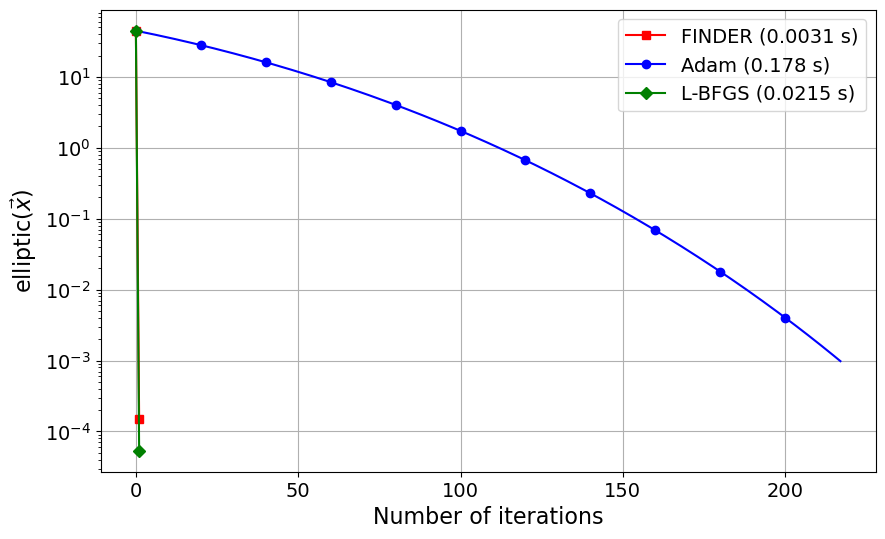

In [127]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery = 1, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 20, label = f'Adam ({runtime_adam} s)')
plt.plot(fx_lbfgs,'gD-', markevery = 1, label = f'L-BFGS ({runtime_lbfgs} s)')

plt.ylabel(rf"{strfitnessfct.__name__}($\vec{{x}}$)", fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(f'plots/IEEE/{strfitnessfct.__name__}.png', bbox_inches='tight', dpi=300)
plt.show()

## save data

In [128]:
torch.save(torch.tensor(fx), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')
torch.save(torch.tensor(fx_adam), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')
torch.save(torch.tensor(fx_lbfgs), f'PlotData/IEEE_functions/{strfitnessfct.__name__}_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')